# Autoencoders using Tensorflow- Part 1

## Contents


*   Introduction
*   Importing libraries and dataset
*   Building the Model
*   Training the model and displaying results





 ## Introduction

The mnist dataset provided in python is a dataset of 70 000 images of handwritten digits (possible labels: from 0 to 9).The dataset is devided into tranining 60 000 examples with their labels and 10 000 test examples with their lables as well. 
Each example is an image represented by a matrix of size an array of 784 elements (this is the flattened version of the 28x28 image).


### Importing libraries and the dataset

In [0]:
import os
import numpy as np
import matplotlib as mpb
import matplotlib.pyplot as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# to make the output of the notebook stable across runs
np.random.seed(42)

# resize the axis to get pretty figure
mpb.rc('axes', labelsize = 15)
mpb.rc('xtick', labelsize = 12)
mpb.rc('ytick', labelsize = 12)

# Import the MNIST dataset
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

print(mnist.train.__class__)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>


In [0]:
print(mnist.train.images.shape)
print(mnist.validation.images.shape)
print(mnist.test.images.shape)

(55000, 784)
(5000, 784)
(10000, 784)


### Building the model 

We are going to define variables, placeholders...of the model 
as well as the architecture of the model before running it in a tensorflow session.


#### 1-Define X, y the input and the respective output of the model 

In [0]:
X = tf.placeholder(tf.float32, shape =(None,784))

In this part we are going to define the different layers structure in the encoder and decoder part. Structure of autoencoder is symmetric. 
#### 2-Define the dimensions of the layers and the respective Weigths and biases of the model with given number of neurons in layers

In [0]:
input_dim = 784
lay1_dim = 256
lay2_dim = 128  ### if 32 or 16, reconstructed image is not so good 
lay3_dim = 256
output_dim = 784

#[batch_size,input_dim] * W     batch_size* lay1_dim   +    b=[1,lay1_dim]   -> batch_size* lay1_dim    1->2->3->4

# encoder weights
Weight_encoder = tf.Variable(tf.random_normal(shape =(input_dim, lay1_dim)))
Weight_encoder1 = tf.Variable(tf.random_normal(shape =(lay1_dim, lay2_dim)))

# encoder biases 
bias_encoder = tf.Variable(tf.zeros(lay1_dim))
bias_encoder1 = tf.Variable(tf.zeros(lay2_dim))    

# decoder weights
Weight_decoder = tf.Variable(tf.random_normal(shape =(lay2_dim, lay3_dim), mean = 0, stddev = 0.5))
Weight_decoder1 = tf.Variable(tf.random_normal(shape =(lay3_dim, output_dim),mean = 0,  stddev = 0.5))

# decoder biases
bias_decoder = tf.Variable(tf.zeros(lay3_dim))          
bias_decoder1 = tf.Variable(tf.zeros(output_dim))

#### 3- Hyperparameters
* Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

* The batch size defines the number of samples that will be propagated through the network.

* An epoch is when an ENTIRE dataset is passed forwards and backwards through the neural network only ONCE.

Here we will define the best hyperparameter that best optimizes the model in order to reconstruct the image.
We look for a combination of hyperparameters which gives the best reocnstruction of the image in an acceptable execution time.
#### 3- Initialize the hyperparameters with some usual values.


In [0]:
Learning_Rate = 0.01
num_epoch = 5
Batch_Size = 1000

In [0]:
help(tf.layers.Dense)

Building an Encoder and Decoder

An autoencoder is composed of two part:
* An encoder that convert the input to an internal representation: h = f(x).
* Decoder: that convert the internal representation to the outputs.

#### 4- Using the weights  and biases defined before, define the functions encode and decode


In [0]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, Weight_encoder),bias_encoder))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, Weight_encoder1), bias_encoder1))
    return layer_2
    
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(x, Weight_decoder),tf.cast(bias_decoder, tf.float32)))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, Weight_decoder1),tf.cast(bias_decoder1,tf.float32)))
    
    return layer_4

    #sqre(2/n)*normal_distrition

    #sqre(1/n)*normal_distrition  Xaviea tanh 


En_layer_1=tf.compat.v1.layers.dense(X,lay1_dim,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=None))
EN_layer_2=tf.compat.v1.layers.dense(En_layer_1,lay2_dim,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=None))


DE_layer_1=tf.compat.v1.layers.dense(EN_layer_2,lay3_dim,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=None))
DE_layer_2=tf.compat.v1.layers.dense(DE_layer_1,output_dim,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=None))

# Define model
#Encoder = encoder(X)
#Decoder = decoder(Encoder)

Encoder = EN_layer_2
Decoder = DE_layer_2


# prediction and target
X_true, X_pred = X, Decoder

# Loss
loss = tf.reduce_mean(tf.pow(X_true - X_pred, 2))
#train_step = tf.train.AdagradOptimizer(Learning_Rate).minimize(loss)
train_step = tf.train.RMSPropOptimizer(Learning_Rate).minimize(loss)

In [0]:
X_true

<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>

### Training the model and displaying results
The entire model already defined, we can now train it.

#### 5- Making the necessary changes and training the model. Afterwards, testing it on the test dataset.


In [0]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print('Training...')
    for epoch in range(1, 10):
        num_batch = mnist.train.num_examples//Batch_Size
        
        for batch in range(num_batch):
            #batch_x, batch_y = mnist.train.next_batch(Batch_Size)
           # a[i:i+batch_size]
            batch_x = mnist.train.images[np.arange(batch*Batch_Size, Batch_Size + batch*Batch_Size)]
            sess.run(train_step, feed_dict={X:batch_x})
       # decoded_imgs=sess.run(Decoder,feed_dict={X:batch_x})
        #decoded_imgs = Decoder.eval({X: batch_x})
       # feed_dict = {X_true: batch_x}
        train_loss=sess.run(loss,feed_dict={X: batch_x})
       # train_loss = loss.eval(feed_dict)
        print("epoch: {} | loss: {}".format(epoch,train_loss)) 
   # sess.run()
    decoded_imgs = Decoder.eval({X: mnist.test.images})
    #decoded_imgs = sess.run(Decoder, feed_dict={X: mnist.test.images})
    
    feed_dict = {X: mnist.test.images}
    print('loss over test set:', loss.eval(feed_dict))


Training...
epoch: 1 | loss: 0.117451012134552
epoch: 2 | loss: 0.087006576359272
epoch: 3 | loss: 0.07689061760902405
epoch: 4 | loss: 0.04965779557824135
epoch: 5 | loss: 0.05297408252954483
epoch: 6 | loss: 0.0424184687435627
epoch: 7 | loss: 0.03638306260108948
epoch: 8 | loss: 0.03154412657022476
epoch: 9 | loss: 0.03360460698604584
loss over test set: 0.03179211


In [0]:
batch_x, batch_y = mnist.train.next_batch(0)
batch_x

array([], shape=(0, 784), dtype=float32)

In [0]:
decoded_imgs.shape

(10000, 784)

In [0]:
mnist.train.next_batch?


#### 6- Displaying the original and the reconstructed model for a few examples

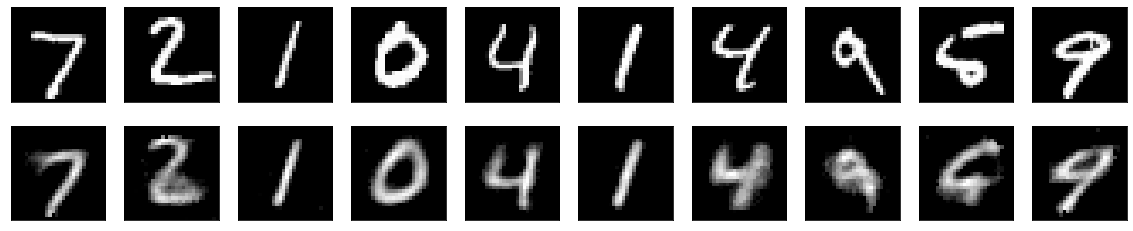

In [0]:
examples_to_show = 10

x_test = mnist.test.images

plt.figure(figsize=(20, 4))
for i in range(examples_to_show):
    # display original
    ax = plt.subplot(2, examples_to_show, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    #plt.imread('png')
    #scipy.imread()
    #PIL
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, examples_to_show, i + 1 + examples_to_show)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
   # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
